### Set everything up

In [200]:
import seaborn as sns
from pandas_profiling import ProfileReport
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LassoCV
from statsmodels.gam.api import GLMGam, BSplines

%matplotlib inline

In [141]:
# small dataset to play with
planets = sns.load_dataset("planets")
profile = ProfileReport(planets, title="Pandas Profiling Report", explorative=True, progress_bar=False)

In [142]:
profile.to_notebook_iframe()

In [143]:
planets

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300000,7.10,77.40,2006
1,Radial Velocity,1,874.774000,2.21,56.95,2008
2,Radial Velocity,1,763.000000,2.60,19.84,2011
3,Radial Velocity,1,326.030000,19.40,110.62,2007
4,Radial Velocity,1,516.220000,10.50,119.47,2009
...,...,...,...,...,...,...
1030,Transit,1,3.941507,NaN,172.00,2006
1031,Transit,1,2.615864,NaN,148.00,2007
1032,Transit,1,3.191524,NaN,174.00,2007
1033,Transit,1,4.125083,NaN,293.00,2008


In [163]:
# make year a better endog variable
planets["years_since"] = planets["year"] - np.min(planets["year"])

# add a constant
planets["const"] = 1

# get additional binary variable for number==1
planets["number1"] = planets_comp["number"]
planets.loc[planets["number1"]!=1, "number1"] = 0

#complete cases only
planets_comp = planets.dropna(axis=0, how='any')

In [164]:
planets_comp

,method,number,orbital_period,mass,distance,year,years_since,const,number1
0,Radial Velocity,1,269.30000,7.100,77.40,2006,17,1,1.0
1,Radial Velocity,1,874.77400,2.210,56.95,2008,19,1,1.0
2,Radial Velocity,1,763.00000,2.600,19.84,2011,22,1,1.0
3,Radial Velocity,1,326.03000,19.400,110.62,2007,18,1,1.0
4,Radial Velocity,1,516.22000,10.500,119.47,2009,20,1,1.0
...,...,...,...,...,...,...,...,...,...
640,Radial Velocity,1,111.70000,2.100,14.90,2009,20,1,1.0
641,Radial Velocity,1,5.05050,1.068,44.46,2013,24,1,1.0
642,Radial Velocity,1,311.28800,1.940,17.24,1999,10,1,1.0
649,Transit,1,2.70339,1.470,178.00,2013,24,1,1.0


## Interpretable Models

### Linear Regression

In [146]:
# linear regression
X = planets[["distance", "mass", "orbital_period", "number"]]
X = sm.add_constant(X)
mod = sm.OLS(planets[["years_since"]], X, missing="drop")
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            years_since   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     15.49
Date:                Sun, 19 Jun 2022   Prob (F-statistic):           6.09e-12
Time:                        12:47:35   Log-Likelihood:                -1387.4
No. Observations:                 498   AIC:                             2785.
Df Residuals:                     493   BIC:                             2806.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             16.3379      0.459     35.

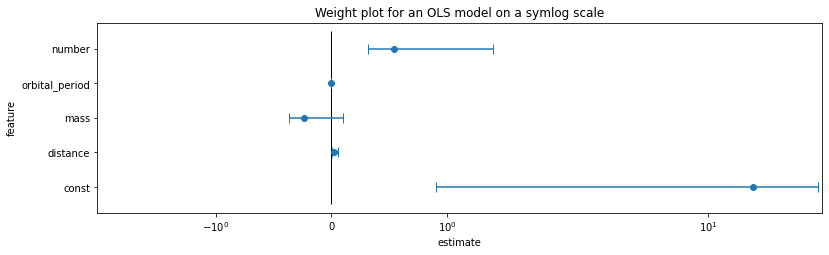

In [147]:
# weight plot
def weight_plot(params, conf_int, title="", scale="linear"):
    params = params
    errors = np.swapaxes(conf_int.to_numpy(), 0, 1)
    y = pd.Series(range(0,len(params))) + 0.5

    fig = plt.figure(figsize=(13,0.7*len(params)))
    plt.vlines(x=0, ymin=0, ymax=len(params), color='black', lw=1)
    plt.errorbar(params, y, xerr=errors, ls="", marker="o", capsize=5)
    plt.yticks(y, params.index)
    plt.xscale(scale)
    plt.title(title)
    plt.xlabel("estimate")
    plt.ylabel("feature")
    

weight_plot(res.params, res.conf_int(), title="Weight plot for an OLS model on a symlog scale", scale="symlog")
plt.show()

In [148]:
# LASSO regression 
exp_var = ["const", "distance", "mass", "orbital_period", "number"]
X = planets_comp[exp_var].to_numpy()
y = planets_comp["years_since"].to_numpy()


reg = LassoCV(cv=20, random_state=0).fit(X, y)
reg.score(X, y)

0.10283198257313131

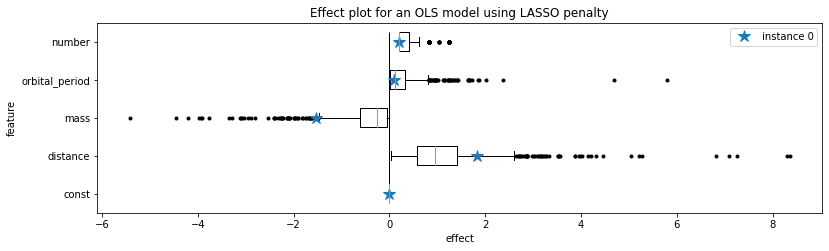

In [149]:
# effect plot
def effect_plot(data, var, coef, instance=None, title=""):
    effects = data.loc[:, var]
    for coef, name in zip(coef, var):
        effects.loc[:, name] = effects[name]*coef

    fig = plt.figure(figsize=(13,0.7*len(var)))
    plt.vlines(x=0, ymin=0.75, ymax=len(var)+0.25, color='black', lw=1)
    plt.boxplot(effects, vert=False, flierprops = dict(marker='o', markerfacecolor='black', markersize=3))
    plt.yticks(range(1, len(var)+1), var)
    plt.title(title)
    plt.xlabel("effect")
    plt.ylabel("feature")
    
    if type(instance) == int:
        data_intance = effects.iloc[instance]
        plt.plot(data_intance[var], range(1, len(var)+1), marker="*", lw=0, markersize=12, 
             label="instance " + str(instance))
        plt.legend()


effect_plot(planets_comp, exp_var, reg.coef_, instance=0, title="Effect plot for an OLS model using LASSO penalty")
plt.show()

### Linear Regression Extensions

In [170]:
# logistic regression
exp_var = ["const", "distance", "mass", "orbital_period", "year"]
target = "number1"
X = planets_comp[exp_var]
y = planets_comp[target]

log_reg = sm.Logit(y, X).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.609286
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                number1   No. Observations:                  498
Model:                          Logit   Df Residuals:                      493
Method:                           MLE   Df Model:                            4
Date:                Sun, 19 Jun 2022   Pseudo R-squ.:                 0.09966
Time:                        13:07:03   Log-Likelihood:                -303.42
converged:                       True   LL-Null:                       -337.01
Covariance Type:            nonrobust   LLR p-value:                 8.971e-14
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            147.6687     49.831      2.963      0.003      50.002     245.336
distance         

In [199]:
# interpretation
for val, name, p in zip(log_reg.params, log_reg.params.index, log_reg.pvalues):
    if (p<0.05) & (name != "const"):
        i_str = 'An increase of feature "{name}" by one unit changes the odds for "{target}" by a factor of {factor:.2f}, c. p..'
        print(i_str.format(name=name, target=target, factor=np.exp(val)))

An increase of feature "distance" by one unit changes the odds for "number" by a factor of 1.02, c. p..
An increase of feature "mass" by one unit changes the odds for "number" by a factor of 1.13, c. p..
An increase of feature "year" by one unit changes the odds for "number" by a factor of 0.93, c. p..


In [194]:
# generalized linear model (GLM)
exp_var = ["const", "distance", "mass", "orbital_period", "year"]
target = "number"
X = planets_comp[exp_var]
y = planets_comp[target]

poisson_reg = sm.GLM(y, X, family=sm.families.Poisson()).fit()
print(poisson_reg.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 number   No. Observations:                  498
Model:                            GLM   Df Residuals:                      493
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -710.21
Date:                Sun, 19 Jun 2022   Deviance:                       248.83
Time:                        14:18:55   Pearson chi2:                     295.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1167
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -44.9061     17.444     -2.

In [198]:
# interpretation
for val, name, p in zip(poisson_reg.params, poisson_reg.params.index, poisson_reg.pvalues):
    if (p<0.05) & (name != "const"):
        i_str = 'for a one unit change in "{name}", the difference in the logs of expected counts is expected to change by {factor:.2f}, c. p..'
        print(i_str.format(name=name, target=target, factor=np.exp(val)))         

for a one unit change in "distance", the difference in the logs of expected counts is expected to change by 0.99, c. p..
for a one unit change in "mass", the difference in the logs of expected counts is expected to change by 0.97, c. p..
for a one unit change in "year", the difference in the logs of expected counts is expected to change by 1.02, c. p..


In [226]:
# generalized additive model (GAM)
x_spline = planets_comp[["orbital_period"]] #["const", "distance", "mass", "orbital_period", "year"]
bs = BSplines(x_spline, df=[10], degree=[3])

alpha = np.array([8283989284.5829611]) # not estimated: this is why you don't do statistics in python

gam_bs = GLMGam.from_formula('mass ~ const', data=planets_comp,
                             smoother=bs, alpha=alpha)
res_bs = gam_bs.fit()
print(res_bs.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   mass   No. Observations:                  498
Model:                         GLMGam   Df Residuals:                   493.90
Model Family:                Gaussian   Df Model:                         3.10
Link Function:               identity   Scale:                          12.113
Method:                         PIRLS   Log-Likelihood:                -1325.7
Date:                Sun, 19 Jun 2022   Deviance:                       5982.7
Time:                        15:06:41   Pearson chi2:                 5.98e+03
No. Iterations:                     3   Pseudo R-squ. (CS):            0.09304
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.7311      0.11

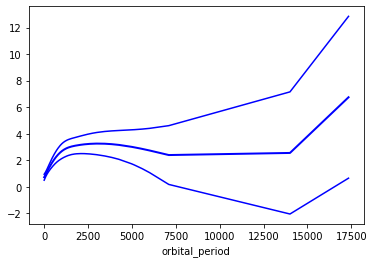

In [229]:
# interpretation (PDP I think)
res_bs.plot_partial(0)
plt.show()

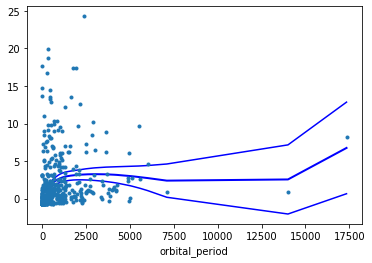

In [230]:
res_bs.plot_partial(0, cpr=True)
plt.show()

### Decision Trees